In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 400)
pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('isplay.max_colwidth', 300)
import re
import matplotlib.pyplot as plt
import IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from sklearn.model_selection import train_test_split
from nltk.tokenize import RegexpTokenizer
from collections import Counter 
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
import nltk
nltk.download('stopwords')
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
from sklearn.cluster import KMeans
from sklearn import metrics
import seaborn as sns


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


 # FINAL CAPSTONE PROJECT
 # Doing NLP with the Tim Ferriss Podcast
 ## Topic Modeling, Clustering and QnA
 #### Goal: Fast access of knowledge from the Tim Ferriss Show Podcast, whenever you need it
 ##### Problem
 The thing is, you listen to a lot of podcasts of the Tim Ferriss Show and there are a lot of things in there you would like to apply to your life but you mostly forget about it after some while.
 Sometimes you are in a specific situation or you have a challenge to tackle and you ask yourself “What would Tim Ferris and his tribe of mentors do here? But you cannot remember anything and let this question unanswered.

## Data set
 * Scraping https://tim.blog/2018/09/20/all-transcripts-from-the-tim-ferriss-show/ with the Python package BeautifulSoup
 * Output: csv file with all podcast episodes of number 151 - 375
 * all podcast of number before 151 do not have a HTML page
 
### What is the podcast "The Tim Ferriss Show" about?
On the website https://tim.blog/podcast/ writes:
Each episode, I deconstruct world-class performers from eclectic areas (investing, sports, business, art, etc.) to extract the tactics, tools, and routines you can use.  This includes favorite books, morning routines, exercise habits, time-management tricks, and much more.
This happens trough a long-time interview format. Tim is asking the guests question. This should be a perfect for QnA model.
### Exploring the data

In [4]:
# Import raw data
# This data set contains the transcripts of the Tim Ferriss Podcasts
# Source: https://tim.blog/2018/09/20/all-transcripts-from-the-tim-ferriss-show/
df = pd.read_csv("raw/transcript-151-3XX.csv")
df.columns=['id', 'title', 'text']
df.head()

# Cleaning the titles
df['title'] = df['title'].str.replace(r"The Tim Ferriss Show Transcripts: ", "")
df['title'] = df['title'].str.replace(r"Transcripts: ", "")
df['title'] = df['title'].str.replace(r"Tim Ferriss Show Transcript: ", "")
df['title'] = df['title'].str.replace(r"Episode ", "")

# Cleaning the transcript text
def clean_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"\\n\\n'", "")
    df[text_field] = df[text_field].str.replace(r"\\n", " ")
    df[text_field] = df[text_field].str.replace(r"\\xa0", " ")
    df[text_field] = df[text_field].str.replace(r"xa0", " ")
    return df
df = clean_text(df, "text")
df.head()



,id,title,text
0,151,Caroline Paul (#151),"'Maria said that Caroline is all about living courageously and embracing adventure in our culture of safe achievement. That is music to my ears. I feel like we’ve grown soft and weak, and it is time to remedy that with habits, practices, and stories that impart lessons.''On top of that, Caroline..."
1,152,On Philosophy and Riches (#152),"'And Seneca takes a little while with his preamble to get warmed up, but my favorite portion begins with: I might close my letter at this point. So you can use that as a bookmark. I might close my letter at this point. And I was talking to a friend of mine about Seneca. He’s a huge fan, also. An..."
2,153,BJ Miller (#153),"'Well, it turns out, BJ Miller, M.D., Dr. Miller, knows exactly this. BJ is a palliative care physician at Zen Hospice Project in San Francisco where he thinks deeply about how to create a dignified, graceful end of life for his patients. Now, this is, of course, not one of the usual suspects yo..."
3,154,Paulo Coelho (#154),"'His books of near universal appeal span from The Alchemist to the most recent, Adultery. And his work has been translated into more than 70 languages. Who knew there were even 70 languages on the planet? And few people know that The Alchemist, which was sold to an original Brazilian publisher, ..."
4,155,On Zero-to-Hero Transformations (#155),"'Instead, I am answering questions that you all or I should say many of you, wanted me to answer. There have been requests for me to do a Q&A, and I went onto the Facebook, www.Facebook.com/timferriss, and linked to a Reddit post where I had people submit and up-vote questions. At least 100 of..."


Word token view:
3391754 words total, with a vocabulary size of 46322
Max episode length is 36769
Mean episode length is 15074.462222222222
Standard deviation for episode length is 6869.436102339725
95 percent std upper bound episode length is 28813.334426901674
95 percent std lower bound episode length is 1335.5900175427723


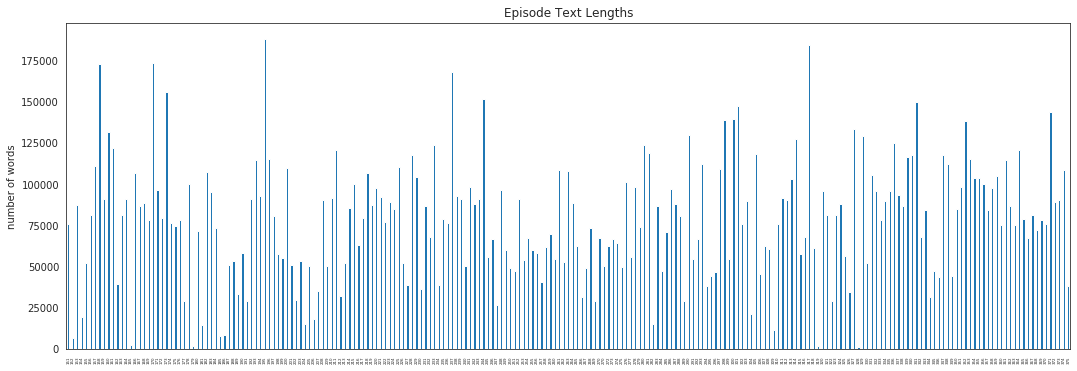

In [8]:
# Print out some stats
regexp_tokenizer = RegexpTokenizer(r'\w+')
df["tokens"] = df["text"].apply(regexp_tokenizer.tokenize)

# Inspecting our dataset a little more
all_words = [word for tokens in df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("Word token view:")
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max episode length is %s" % max(sentence_lengths))
print("Mean episode length is %s" % np.mean(sentence_lengths))
print("Standard deviation for episode length is %s" % np.std(sentence_lengths))
print("95 percent std upper bound episode length is %s" % str(np.mean(sentence_lengths) + np.std(sentence_lengths) * 2))
print("95 percent std lower bound episode length is %s" % str(np.mean(sentence_lengths) - np.std(sentence_lengths) * 2))

# Plot episode text lengths
plt.figure(figsize=(18, 6))
ax = df.text.str.len().plot.bar(1, title='Episode Text Lengths')
ax.set_xticklabels(df.id, rotation=90, size=4)
ax.set_ylabel("number of words")
plt.show()

# Get labels
label = df["title"].tolist()


 ### First findings
 This data set is large enough to do some serious NLP. Dealing with a very long document size will be challenge.
 We also have a high variance regarding the episode text length. Some episodes are really short others are quite long. Imagine that some podcast have a audio lenght of more than 3h makes this not a surprise. The word token view supports this finding.

## Topic Modeling and Extraction
 To get a first impression this section will be doing some topic modeling and extraction.
 Applying a custom list of stop words is important here.
 A seperated python code will be load into this notebook to remove these stopwords.

#### Experiments
 * Used different number of topics (4, 5, 6)
 * Tried different parameter in each model

#### NNFM
* Set alpha from 0 to 0.1 --> much better results

In [4]:
from custom_stopwords import remove_custom_stopwords

# Parameters to set:
# Number of topics.
ntopics=4
# Number of words to look at for each topic.
n_top_words = 10

# Creating a dataframe to store the topic extraction results
topwords=pd.DataFrame()

# copy dataframe to convert the transcript to lower case
df_topic = df.copy()
df_topic['text'] = df_topic['text'].str.lower()

# Creating the tf-idf matrix.
vectorizer = TfidfVectorizer(stop_words=set(stopwords.words('english')), min_df=3, norm='l2')
podcasts_tfidf = vectorizer.fit_transform(remove_custom_stopwords(df_topic, 'text').text)

# Getting the word list.
terms = vectorizer.get_feature_names()

# Linking words to topics
def word_topic(tfidf,solution, wordlist):
    
    # Loading scores for each word on each topic/component.
    words_by_topic=tfidf.T * solution

    # Linking the loadings to the words in an easy-to-read way.
    components=pd.DataFrame(words_by_topic,index=wordlist)
    
    return components

# Extracts the top N words and their loadings for each topic.
def top_words(components, n_top_words):
    topwords=pd.Series()
    for column in range(components.shape[1]):
        # Sort the column so that highest loadings are at the top.
        sortedwords=components.iloc[:,column].sort_values(ascending=False)
        # Choose the N highest loadings.
        chosen=sortedwords[:n_top_words]
        #print(chosen)
        # Combine loading and index into a string.
        for i, data in enumerate(chosen):
            chosenlist=chosen.index.values.tolist()[i] +" "+ str(round(data ,2))
            topwords = topwords.append(pd.Series([chosenlist], index=[column]))
    return(topwords)

# LSA
svd = TruncatedSVD(n_components=ntopics)
lsa_pipe = make_pipeline(svd, Normalizer(copy=False))
podcasts_lsa = lsa_pipe.fit_transform(podcasts_tfidf)

components_lsa = word_topic(podcasts_tfidf, podcasts_lsa, terms)

topwords['LSA'] = top_words(components_lsa, n_top_words) 

# LDA
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=ntopics, 
          doc_topic_prior=1/ntopics,
          topic_word_prior=1/ntopics,
          learning_decay=0.6, # Convergence rate.
          learning_offset=5.0, # Causes earlier iterations to have less influence on the learning
          max_iter=500, # when to stop even if the model is not converging (to prevent running forever)
          evaluate_every=3, # Do not evaluate perplexity, as it slows training time.
          mean_change_tol=0.001, # Stop updating the document topic distribution in the E-step when mean change is < tol
          max_doc_update_iter=100, # When to stop updating the document topic distribution in the E-step even if tol is not reached
          n_jobs=-1, # Use all available CPUs to speed up processing time.
          verbose=0, # amount of output to give while iterating
          random_state=32
         )

podcasts_lda = lda.fit_transform(podcasts_tfidf) 

components_lda = word_topic(podcasts_tfidf, podcasts_lda, terms)

topwords['LDA']=top_words(components_lda, n_top_words)

# NNMF

from sklearn.decomposition import NMF

nmf = NMF(alpha=0.1, 
          init='nndsvdar', # how starting value are calculated
          l1_ratio=0.5, # Sets whether regularization is L2 (0), L1 (1), or a combination (values between 0 and 1)
          max_iter=400, # when to stop even if the model is not converging (to prevent running forever)
          n_components=ntopics, 
          random_state=65, 
          solver='cd', # Use Coordinate Descent to solve
          tol=0.0001, # model will stop if tfidf-WH <= tol
          verbose=0 # amount of output to give while iterating
         )
podcasts_nmf = nmf.fit_transform(podcasts_tfidf) 

components_nmf = word_topic(podcasts_tfidf, podcasts_nmf, terms)

topwords['NNMF']=top_words(components_nmf, n_top_words)

#Show topics
for topic in range(ntopics):
    print('Topic {}:'.format(topic))
    print(topwords.loc[topic])


Topic 0:
            LSA          LDA         NNMF
0  people 31.98  people 0.35  people 8.19
0   think 29.43   think 0.32   think 7.66
0     one 26.74     one 0.29     one 6.76
0    time 19.67    time 0.21    time 5.01
0    know 17.53    know 0.19    know 4.49
0  things 17.41  things 0.19  things 4.49
0     say 16.63     say 0.18     say 4.26
0      go 15.25    want 0.17      go 3.89
0    want 15.22      go 0.17    want 3.87
0     lot 14.52     lot 0.16     lot 3.74
Topic 1:
              LSA          LDA            NNMF
1        diet 1.1  people 0.35  ketogenic 0.96
1  ketogenic 1.05   think 0.32       diet 0.81
1   training 0.81     one 0.29    ketones 0.41
1       body 0.65    time 0.21    ketosis 0.36
1    glucose 0.56    know 0.19    glucose 0.35
1      coach 0.54  things 0.19     ketone 0.33
1     muscle 0.52     say 0.18      think 0.28
1    ketones 0.52    want 0.17     oxygen 0.27
1   strength 0.51      go 0.17       beta 0.23
1    ketosis 0.47     lot 0.16        one 0.21
Top

 ### Findings
 * 4 topics have the best consistency troughout the two models LSA and NNFM. They show similar top words.
 * 4 topics also make sense if you consider the words semantics
 * LDA performance poorly. It contains the same top words in each topic. Probably a sign of converging to an local optima.
 * NNFM performance the best. Here the top words are better related to each other than in LSA.

#### Found topics:
 1. Ketogenic diet
 2. Training
 3. Psychedelics
 4. All other

 ## Tokenize with pre-trained language model
 It is time to use current advances in NLP by using common transformer architectures pre-trained on a large corpus of text like from the Wikipedia.
 ### Experiments
 * Used Distill Bert, Bert, XLNet
 * uncased and cased
 * Clustering (number of cluster is 4, like the best number of topics, which was a finding of the topic modeling part)
 * metric: silhouette_score

In [2]:
#Load transformer Model
nlp = spacy.load('/usr/local/lib/python3.7/site-packages/en_pytt_xlnetbasecased_lg/en_pytt_xlnetbasecased_lg-2.1.1')
n_items = 86 # Enough data for this show case


In [5]:
# Vectorize transcripts with spacy  
def get_embeddings_with_spacy(tokenizer, df):
    embeddings = df['text'].apply(lambda x: tokenizer(x).vector)
    return list(embeddings)

spacy_transformer_embeddings = get_embeddings_with_spacy(nlp, df[:n_items])


In [6]:
# Create dataframe
df_emb_spacy = pd.DataFrame(spacy_transformer_embeddings)

# Normalize 
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(df_emb_spacy) 
df_emb_spacy.loc[:,:] = scaled_values


silhouette score:  0.2785538073001246


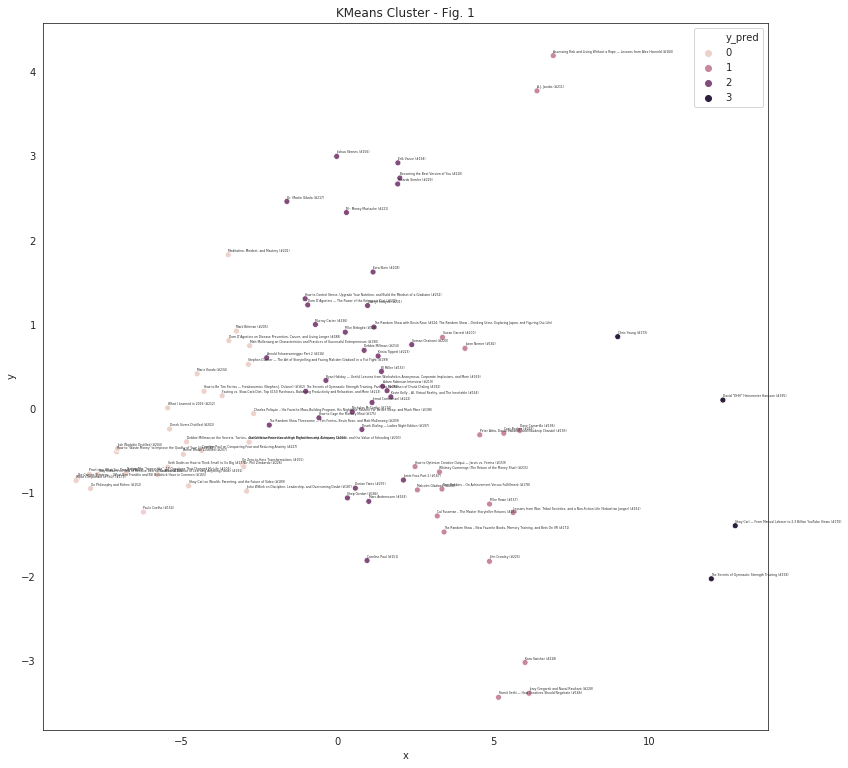

In [10]:
# Clustering 

# Calculate predicted values.
km = KMeans(n_clusters=4, random_state=42).fit(df_emb_spacy)
y_pred = km.predict(df_emb_spacy)

print('silhouette score: ', metrics.silhouette_score(df_emb_spacy, y_pred, metric='euclidean'))

# 2D
lsa = PCA(n_components=2)
las_results = lsa.fit_transform(df_emb_spacy.values)
las_results = pd.DataFrame(las_results, columns=['x', 'y'])

df_y = pd.DataFrame(y_pred, columns=['y_pred'])
df_y['y_pred'] = df_y['y_pred'].astype(int)

las_results = pd.concat([las_results, df_y], axis=1)

#Plot
sns.set_style("white")
plt.figure(figsize=(13, 13))  
fig = sns.scatterplot(x=las_results['x'], y=las_results['y'], hue=las_results['y_pred'])
for i, txt in enumerate(label[:n_items]):
    fig.annotate(txt, # this is the text
                 (las_results['x'].values[i],las_results['y'].values[i]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,3), # distance from text to points (x,y)
                 ha='left', # horizontal alignment can be left, right or center
                 size=3)
fig.set_title("KMeans Cluster - Fig. 1", fontsize=12)
plt.show()


 ### Findings:
 WIth more and more clusters the silhouette score is going down. So it is not going to help if you increase the cluster number or regarding the topic modeling part to increase the number of topics.
 With this data set it also is very hard to find clusters in general. It looks like all the topics of the Tim Ferris show are very diverse and seamlessly complete each other. There is no obvious way to divide them. It looks like the clusters have a similar variance. That is why k-Means is not working well here.

Episodes which are close to each other should have something in common. Here we used a pre-trained model, called XLNet. This new class of models try to encode the contextual information of a sentences or words in a given document. Does this mean that proxmity says something how close the context of two podcast episode are? In the first place I would think yes. But taking a look at the plot, as a frequent listener I cannot identify any realtion between episodes. Probaly the encoding is unique for each document(episode) because there is allways a diffente context present. 

#### Things to do next:
* use a different vectorizer like TFIDF, Word2Vec
* try other cluster algorithms
* try to find cluster manually before hand to have a better evaluation metric

 ## Question and Answering (QnA)
 ### Building a Tim Ferriss Bot
 The goal is to build a question and answering system with the podcast transcript corpus.
 This project experiments first with cdQA, an End-To-End Closed Domain Question Answering System Framework: https://cdqa-suite.github.io/cdQA-website/
 
This QnA system will be a closed domain one, because we are only using the given transcripts and we are only think about questions which should have an answer in this data set.

In [8]:
# Create paragraphs
# Use the interview structure and split it when Tim Ferriss starts to aks a question
# If the podcast transcript has no structured interview then remove it from the data set
# The treshold is 7. That means we could not split the transcript into 7 different pieces. 
df['paragraphs'] = df['text'].apply(lambda x: x.split("''Tim Ferriss:") if len(x.split("''Tim Ferriss:")) > 7 else None)

# Define X
df_X = df.drop(columns=['text', 'id']).dropna()
df_X.reset_index(drop=True, inplace=True)

def remove_short_parparagraphs(paragraphs):
    for para in paragraphs:
        if len(para) < 450:
            #print(len(para))
            paragraphs.remove(para)
    return paragraphs

df_X['paragraphs'] = df_X['paragraphs'].apply(lambda x: remove_short_parparagraphs(x))

# Generate squad v1.1 json file so you can create annotated question and answers to fine-tune the model and evaluate it
from cdqa.utils.converters import df2squad
json_data = df2squad(df=df_X, squad_version='v1.1', output_dir='.', filename='qna_tim_ferriss_v2')
# From there we can use https://github.com/cdqa-suite/cdQA-annotator to create a supervised problem


177it [00:00, 7507.32it/s]


 ### Fine-Tuning

In [9]:
# Fine-tune Bert model with squad v1.1 custom data set of Tim Ferriss questions
import os
import torch
from sklearn.externals import joblib
from cdqa.reader.bertqa_sklearn import BertProcessor, BertQA

train_processor = BertProcessor(do_lower_case=True, is_training=True)
train_examples, train_features = train_processor.fit_transform(X='cdqa-v1.1-tim_qna.json')

reader = BertQA(train_batch_size=12,
                learning_rate=3e-5,
                num_train_epochs=2,
                do_lower_case=True,
                output_dir='models')

reader.fit(X=(train_examples, train_features))

# Output fine-tuned model
reader.model.to('cpu')
reader.device = torch.device('cpu')
joblib.dump(reader, os.path.join(reader.output_dir, 'bert_tim_qa_vCPU.joblib'))


Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.
Training beyond specified 't_total'. Learning rate multiplier set to 0.0. Please set 't_total' of WarmupLinearSchedule correctly.


['models/bert_tim_qa_vCPU.joblib']

 ### Training

In [10]:
from cdqa.pipeline.cdqa_sklearn import QAPipeline

# Load standard model
cdqa_pipeline = QAPipeline(model='./models/bert_tim_qa_vCPU.joblib', max_answer_length=60)
cdqa_pipeline.fit_retriever(X=df_X[:3].copy())



QAPipeline(reader=BertQA(bert_model='bert-base-uncased', do_lower_case=True,
                         fp16=False, gradient_accumulation_steps=1,
                         learning_rate=5e-05, local_rank=-1, loss_scale=0,
                         max_answer_length=60, n_best_size=20, no_cuda=False,
                         null_score_diff_threshold=0.0, num_train_epochs=3.0,
                         output_dir=None, predict_batch_size=8, seed=42,
                         server_ip='', server_port='', train_batch_size=32,
                         verbose_logging=False, version_2_with_negative=False,
                         warmup_proportion=0.1))

In [11]:
# Evaluate QnA system
from cdqa.utils.evaluation import evaluate_pipeline
evaluate_pipeline(cdqa_pipeline, 'cdqa-v1.1-tim_qna.json')

# Standard pre trained model: {'exact_match': 0.0, 'f1': 5.912511958008912}

3it [00:00, 1396.55it/s]
3it [00:00, 1432.15it/s]
3it [00:00, 1379.71it/s]
3it [00:00, 1359.14it/s]
3it [00:00, 1433.79it/s]
3it [00:00, 1407.96it/s]
3it [00:00, 1447.81it/s]
3it [00:00, 1367.71it/s]
3it [00:00, 1448.81it/s]
3it [00:00, 1299.08it/s]
3it [00:00, 1392.99it/s]
3it [00:00, 1387.92it/s]
3it [00:00, 1362.82it/s]
3it [00:00, 1361.79it/s]
3it [00:00, 1176.19it/s]
3it [00:00, 1401.37it/s]
3it [00:00, 1353.87it/s]
3it [00:00, 1311.40it/s]
3it [00:00, 1278.36it/s]
3it [00:00, 1391.76it/s]
3it [00:00, 1281.49it/s]
3it [00:00, 1281.09it/s]
3it [00:00, 1338.04it/s]
3it [00:00, 1370.09it/s]
3it [00:00, 1341.03it/s]
3it [00:00, 1394.38it/s]
3it [00:00, 1346.92it/s]
3it [00:00, 1202.73it/s]
3it [00:00, 1345.19it/s]
3it [00:00, 1397.95it/s]
3it [00:00, 1279.01it/s]
3it [00:00, 1360.90it/s]
3it [00:00, 1332.09it/s]
3it [00:00, 1459.23it/s]
3it [00:00, 1199.06it/s]
3it [00:00, 1395.62it/s]
3it [00:00, 1323.96it/s]
3it [00:00, 1183.16it/s]
3it [00:00, 1380.01it/s]
3it [00:00, 1347.50it/s]


{'exact_match': 0.0, 'f1': 7.25635445681709}

 ### Inference

In [12]:
prediction = cdqa_pipeline.predict(X='Who was the author of The Gutsy Girl: Escapades for Your Life of Epic Adventure?')
print('title: {}'.format(prediction[1]))
print('paragraph: {}'.format(prediction[2]))
print('answer: {}'.format(prediction[0]))


3it [00:00, 1205.49it/s]


title: Joshua Skenes (#156)
paragraph:  Room turns meaning somebody wouldn’t get up and get replaced by another diner.''Joshua Skenes: Right, exactly – in today’s real estate, for the cost of renting a place and paying for labor and all of these other things; insurances, and taxes and all that shit you have to do more than one seating. You have to get as many people in there as you can which is a very sad state of restaurants especially when you’re trying to do things that are really amazing or give people a great experience. So, this was just a little eight-seat workshop essentially and so he cooked in there for a little while. We would do some collaboration dinners and it was really great but then I realized we’re still in the city.''There’s only so much you can do on a busy street with a dump truck driving by so I’ve been working on some new stuff and one day I’ll be able to tell you about it.
answer: while. We would do some collaboration dinners and it was really great but then I r

 ### Findings:
 * F1 score is really low --> not a good QnA model
 * Inferene is very slow on mediocre hardware
 * Inference results are also bad, not even one hitting example was found. 

### Identified issues
 * too many paragraphs --> initial choice on the document to find the answer in is too hard for tf-idf
 * too many paragraphs with too short text, bad for tf-idf and to predict the answer (even some contrains were already implemented
 * too long length of the answer
 * too slow hardware
 * even the paragraphs dervied from an interview text are not fitting to this problem right away, Tim Ferriss is not asking a lot of good fitting question
 * in this podcast they are tell more stories than asking and answering questions --> this makes it harder to find QnA pairs and to learn from the corpus.
 
### Next step
Get rid of the tfidf document searching part in this QnA system. Now we provide the context/text and the question as an input, not only the question. 

In [1]:
import pprint

from farm.infer import Inferencer
import torch
from farm.modeling.adaptive_model import AdaptiveModel
from farm.modeling.language_model import Bert
from farm.modeling.prediction_head import QuestionAnsweringHead
from farm.data_handler.processor import SquadProcessor
from farm.modeling.tokenization import BertTokenizer
from farm.utils import set_all_seeds


##########################
########## Settings
##########################
set_all_seeds(seed=42)
device = torch.device('cpu')
base_LM_model = "bert-base-cased"
label_list = ["start_token", "end_token"]


# 1.Create a tokenizer
tokenizer = BertTokenizer.from_pretrained(
    pretrained_model_name_or_path=base_LM_model, do_lower_case=False
)

# 2. Create a DataProcessor that handles all the conversion from raw text into a pytorch Dataset
metric = "squad"
processor = SquadProcessor(
    tokenizer=tokenizer,
    max_seq_len=256,
    labels=label_list,
    metric=metric,
    train_filename='',
    dev_filename='',
    test_filename=None,
    data_dir="../data/squad20",
)

# 4. Create an AdaptiveModel
# a) which consists of a pretrained language model as a basis
language_model = Bert.load(base_LM_model)
# b) and a prediction head on top that is suited for our task => Question Answering
prediction_head = QuestionAnsweringHead(layer_dims=[768, len(label_list)])

model = AdaptiveModel(
    language_model=language_model,
    prediction_heads=[prediction_head],
    embeds_dropout_prob=0.1,
    lm_output_types=["per_token"],
    device=device,
)

save_dir = "./saved_models/bert-english-qa-tutorial"
model.save(save_dir)
processor.save(save_dir)
model = Inferencer.load(save_dir)

# Load it & harvest your fruits (Inference)
# Example 1
QA_input = [
        {
            "questions": ["Who was the author of The Gutsy Girl: Escapades for Your Life of Epic Adventure?"],
            "text":  "Maria said that Caroline is all about living courageously and embracing adventure in our culture of safe achievement. That is music to my ears. I feel like we have grown soft and weak, and it is time to remedy that with habits, practices, and stories that impart lessons.''On top of that, Caroline can probably kick my ass  and I am actually not kidding whatsoever about that. She is the author of four published books. The latest is the New York Times bestseller The Gutsy Girl: Escapades for Your Life of Epic Adventure. That does not mean this podcast is only for girls, women, or females. It is about overcoming fear. Once a scaredy-cat herself, Caroline decided fear got in the way of the life she wanted, including a life of excitement, confidence, self-reliance, etc.''She has since fought fires as one of the first female firefighters in San Francisco, flown planes, rafted big rivers, climbed tall mountains  like Denali  and much, much more.''In this episode we discuss various types of fear and how she has overcome them, or minimized them, and how you can do the same. So please enjoy my conversation with Caroline Paul.''Caroline, welcome to the show.''Caroline Paul: Thanks, Tim. I'm really happy to be here."
        }]


result = model.run_inference(dicts=QA_input)

for x in result:
    pprint.pprint(x)



ModuleNotFoundError: No module named 'farm'

In [12]:
# Example 2
QA_input = [
        {
            "questions": ["If you have such low visibility, how do you search for a dead body?"],
            "text":  "It sounds terrifying without the dead body. In that case, the bay is certainly larger than a swimming pool by many orders of magnitude. If you have such low visibility, how do you search for a dead body?''Caroline Paul: The worst way. You feel for a dead body. You swim very slowly with one hand holding a rope because you\u2019re guided from the top. You want to do a certain pattern. The other hand is reaching out very slowly and feeling. If you do the search pattern right, you cover a pretty wide area. And I\u2019ll tell you the things at the bottom of the bay are amazing \u2013 shopping carts, tires, pipes, cans."
        }]

result = model.run_inference(dicts=QA_input)

for x in result:
    pprint.pprint(x)

09/22/2019 12:06:27 - INFO - farm.data_handler.processor -   Got ya 1 parallel workers to fill the baskets with samples (chunksize = 20)...
100%|██████████| 1/1 [00:00<00:00, 132.54it/s]
09/22/2019 12:06:27 - INFO - farm.data_handler.processor -   Got ya 1 parallel workers to featurize samples in baskets (chunksize = 20) ...
100%|██████████| 1/1 [00:00<00:00, 131.97it/s]


{'predictions': [{'context': 'If you have such low visibility, how do you '
                             'search for a dead body?',
                  'end': 304,
                  'label': 'of magnitude. If you have such low visibility, how '
                           "do you search for a dead body?''Caroline Paul: The "
                           'worst way. You feel for a dead body. You swim very '
                           'slowly with one hand holding',
                  'probability': None,
                  'start': 122}],
 'task': 'qa'}


In [13]:
# Example 3
QA_input = [
        {
            "questions": ["Why it is a problem to base all of gymnastics training off muscular fatigue?"],
            "text":  " That\u2019s the story of my life.''Coach Sommer: The story of all of our lives.''I used to tell my athletes there are stupid gymnasts, and there are old gymnasts, but there are no old, stupid gymnasts because they\u2019re all dead. But most people, most beginners, they want to base all of their training off muscular fatigue, which is a problem. It\u2019s problematic because muscle tissue regenerates about every 90 days from end to end, all of the cells, everything is done in 90 days. That\u2019s fine. But connective tissue takes 200 to 210 days. So we have a huge gap. So if I get in, and I\u2019m not a big fan of beginners training to failure simply because their structure isn\u2019t mature enough yet to handle it safely. And by mature, I simply mean enough productive, well structured hours under their belt."
        }]

result = model.run_inference(dicts=QA_input)

for x in result:
    pprint.pprint(x)


09/22/2019 12:06:27 - INFO - farm.data_handler.processor -   Got ya 1 parallel workers to fill the baskets with samples (chunksize = 20)...
100%|██████████| 1/1 [00:00<00:00, 97.75it/s]
09/22/2019 12:06:27 - INFO - farm.data_handler.processor -   Got ya 1 parallel workers to featurize samples in baskets (chunksize = 20) ...
100%|██████████| 1/1 [00:00<00:00, 99.21it/s]


{'predictions': [{'context': 'Why it is a problem to base all of gymnastics '
                             'training off muscular fatigue?',
                  'end': 482,
                  'label': 's, and there are old gymnasts, but there are no '
                           'old, stupid gymnasts because they’re all dead. But '
                           'most people, most beginners, they want to base all '
                           'of their training off muscular fatigue, which is a '
                           'problem. It’s problematic because muscle tissue '
                           'regenerates about every 90 days from end to end, '
                           'all of the cells, everything is done in 90 days. '
                           'That’s',
                  'probability': None,
                  'start': 128}],
 'task': 'qa'}


### Findings
* It is working much better than the previous cdQA model

 ## Conclusion

 This text corpus is way more challenging than expected. Topic modeling and extraction works quite well, but using pre-trained models and state of the art transformer architectues won't give you free lunch. Result are far away from thinking about operationalizing the model.

 #### Things to do next:
 * Fine tune transformer model for clustering, also for QnA model: domain and taks adaption
 * Use a transformer model for topic modeling and extraction
 * Get more QnA pairs
 * Get rid of unhelpful paragraphs for the QnA model
 * Build an API
 * Build a Telegram Chatbot

 ### Miscellaneous

In [0]:
# Fix issue where the id is missing
import uuid
import json

with open('cdqa-v1.1-xxxx.json') as json_file:
    annotated_dataset = json.load(json_file)

for doc in annotated_dataset['data']:
    for p in doc['paragraphs']:
        for qa in p['qas']:
            qa['id'] = str(uuid.uuid4())

with open('cdqa-v1.1-tim_qna.json', 'w') as outfile:
    json.dump(annotated_dataset, outfile)
